![banner](https://learn.responsibly.ai/assets/img/banner.jpg)

# Class 4 - Discrimination & Fairness: Technical Report Playground

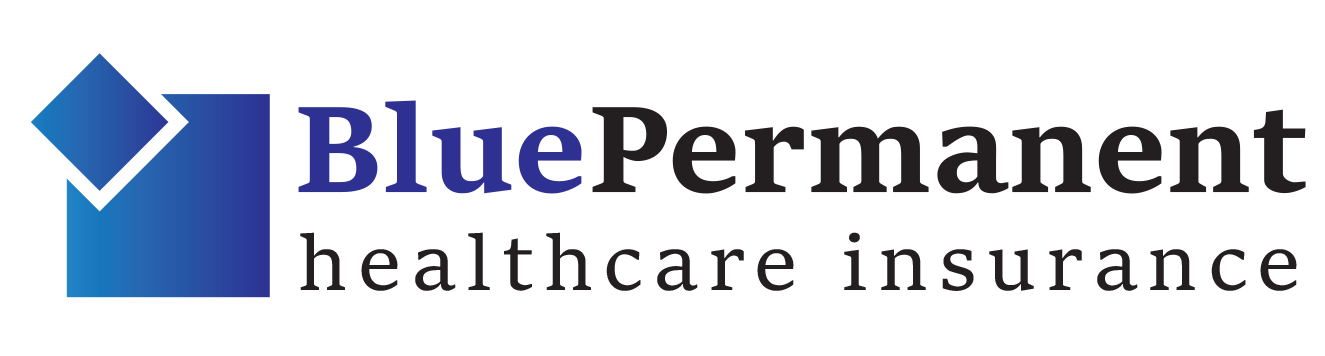

## 1. Setup (NOT IMPORTANT)

In [ ]:
!wget http://stash.responsibly.ai/4-fairness/activity/utils.py -O utils.py -q
!wget http://stash.responsibly.ai/4-fairness/activity/patients_data.csv -O patients_data.csv -q

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from utils import (data_statistics, column_distribution,
                   preprocessing, predict_risk_score,
                   plot_x_vs_y, at_risk_boxplot)

sns.set()

## 2. Dataset (IMPORTANT)

The information here is just for reference and it is copied from the pre-calss task. No need to dive into that as a team, because the Data Science students worked with this dataset at home.

### Meaning of column suffixes (endings)
* _t: indicates this is a time dependent variable from year t (e.g. t = 2020)
* _tm1: indicates this is a time dependent variable from year t minus 1 (t-1) (e.g. if t = 2021 then t - 1 = 2020).

### 1. Variables that can be used as target variables (because they are "at time t")

Outcomes at time t: "outcomes" for a given calendar year (t): cost, health, program enrollment, and the commercial risk score. 

In particular, we have:

| Column Name        | Description                                                                                      | Note                                                                          |
|--------------------|--------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| cost_t             | Total medical expenditures, rounded to the nearest 100                                           | The actual target variable used to train the model and produce the risk score |
| illnesses_sum_t    | Total number of active chronic illnesses                                                         |                                                                               |

### 2. Variables that can be used as "predictors" (features)

* **Demographic**: e.g `gender`, `race`, `age`.
* **Comorbidity variables** at time t-1: indicators for specific chronic comorbidities (illnesses) that were active in the previous year. <br> E.g `liver_elixhauser_tm1` which is an indicator for liver disease.
* **Cost variables** at time t-1: Costs claimed from the patients' insurance payer over the previous year. <br> E.g `cost_laboratory_tm1` which is the total cost for laboratory tests.
* **Biomarker\medication** variables at time t-1: indicators capturing normal or abnormal values (or missingness) of biomarkers or relevant medications, over the previous year. <br> E.g `ghba1c_min-low_tm1` which is an indicator for low (< 4) minimum GHbA1c test result.

An indicator is a binary variable: 1 stands for 'True' or 'Has the condition', 0 stands for 'False' or 'Doesn't Have'.

For a detailed description of the dataset and the columns see [this document](https://docs.google.com/document/d/1hezZuWK87uAGmMcQSn163eHgl_l6SyssaFtdRK51rsQ/edit?usp=sharing), but you don't need it.

The EHR (Electronic Health Record) dataset contains 48,784 rows (patients) and 160 columns/variables. 

In [ ]:
data = pd.read_csv('patients_data.csv')
data.head(5)

,illnesses_sum_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,gender,race,...,sodium_max-normal_tm1,trig_min-low_tm1,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1
0,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,Male,white,...,0,0,0,0,0,0,0,0,0,0
1,3,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,Female,white,...,1,0,0,1,0,0,1,0,0,1
2,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,Female,white,...,0,0,0,0,0,0,0,0,0,0
3,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,Female,white,...,0,0,0,0,0,0,0,0,0,0
4,1,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,Female,white,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Outcome variables at time T (see above)
outcomes_t = ['illnesses_sum_t', 'cost_t']

# Demographic variables at time T-1
demographic_tm1 = ['gender', 'race', 'age']

# Chronic illness condition variables at time T-1
comorbidities_tm1 = ['illnesses_sum_tm1', 'alcohol_elixhauser_tm1', 'anemia_elixhauser_tm1', 'arrhythmia_elixhauser_tm1', 'arthritis_elixhauser_tm1', 'bloodlossanemia_elixhauser_tm1', 'coagulopathy_elixhauser_tm1', 'compdiabetes_elixhauser_tm1', 'depression_elixhauser_tm1', 'drugabuse_elixhauser_tm1', 'electrolytes_elixhauser_tm1', 'hypertension_elixhauser_tm1', 'hypothyroid_elixhauser_tm1', 'liver_elixhauser_tm1', 'neurodegen_elixhauser_tm1', 'obesity_elixhauser_tm1', 'paralysis_elixhauser_tm1', 'psychosis_elixhauser_tm1', 'pulmcirc_elixhauser_tm1', 'pvd_elixhauser_tm1', 'renal_elixhauser_tm1', 'uncompdiabetes_elixhauser_tm1', 'valvulardz_elixhauser_tm1', 'wtloss_elixhauser_tm1', 'cerebrovasculardz_romano_tm1', 'chf_romano_tm1', 'dementia_romano_tm1', 'hemiplegia_romano_tm1', 'hivaids_romano_tm1', 'metastatic_romano_tm1', 'myocardialinfarct_romano_tm1', 'pulmonarydz_romano_tm1', 'tumor_romano_tm1', 'ulcer_romano_tm1']

# Cost variables at time T-1
costs_tm1 = ['cost_dialysis_tm1', 'cost_emergency_tm1', 'cost_home_health_tm1', 'cost_ip_medical_tm1', 'cost_ip_surgical_tm1', 'cost_laboratory_tm1', 'cost_op_primary_care_tm1', 'cost_op_specialists_tm1', 'cost_op_surgery_tm1', 'cost_other_tm1', 'cost_pharmacy_tm1', 'cost_physical_therapy_tm1', 'cost_radiology_tm1']

# Biomarkers (e.g., blood test result) varbles at time T-1
biomarkers_tm1 = ['lasix_dose_count_tm1', 'lasix_min_daily_dose_tm1', 'lasix_mean_daily_dose_tm1', 'lasix_max_daily_dose_tm1', 'cre_tests_tm1', 'crp_tests_tm1', 'esr_tests_tm1', 'ghba1c_tests_tm1', 'hct_tests_tm1', 'ldl_tests_tm1', 'nt_bnp_tests_tm1', 'sodium_tests_tm1', 'trig_tests_tm1', 'cre_min-low_tm1', 'cre_min-high_tm1', 'cre_min-normal_tm1', 'cre_mean-low_tm1', 'cre_mean-high_tm1', 'cre_mean-normal_tm1', 'cre_max-low_tm1', 'cre_max-high_tm1', 'cre_max-normal_tm1', 'crp_min-low_tm1', 'crp_min-high_tm1', 'crp_min-normal_tm1', 'crp_mean-low_tm1', 'crp_mean-high_tm1', 'crp_mean-normal_tm1', 'crp_max-low_tm1', 'crp_max-high_tm1', 'crp_max-normal_tm1', 'esr_min-low_tm1', 'esr_min-high_tm1', 'esr_min-normal_tm1', 'esr_mean-low_tm1', 'esr_mean-high_tm1', 'esr_mean-normal_tm1', 'esr_max-low_tm1', 'esr_max-high_tm1', 'esr_max-normal_tm1', 'ghba1c_min-low_tm1', 'ghba1c_min-high_tm1', 'ghba1c_min-normal_tm1', 'ghba1c_mean-low_tm1', 'ghba1c_mean-high_tm1', 'ghba1c_mean-normal_tm1', 'ghba1c_max-low_tm1', 'ghba1c_max-high_tm1', 'ghba1c_max-normal_tm1', 'hct_min-low_tm1', 'hct_min-high_tm1', 'hct_min-normal_tm1', 'hct_mean-low_tm1', 'hct_mean-high_tm1', 'hct_mean-normal_tm1', 'hct_max-low_tm1', 'hct_max-high_tm1', 'hct_max-normal_tm1', 'ldl_min-low_tm1', 'ldl_min-high_tm1', 'ldl_min-normal_tm1', 'ldl-mean-low_tm1', 'ldl-mean-high_tm1', 'ldl-mean-normal_tm1', 'ldl_max-low_tm1', 'ldl_max-high_tm1', 'ldl_max-normal_tm1', 'nt_bnp_min-low_tm1', 'nt_bnp_min-high_tm1', 'nt_bnp_min-normal_tm1', 'nt_bnp_mean-low_tm1', 'nt_bnp_mean-high_tm1', 'nt_bnp_mean-normal_tm1', 'nt_bnp_max-low_tm1', 'nt_bnp_max-high_tm1', 'nt_bnp_max-normal_tm1', 'sodium_min-low_tm1', 'sodium_min-high_tm1', 'sodium_min-normal_tm1', 'sodium_mean-low_tm1', 'sodium_mean-high_tm1', 'sodium_mean-normal_tm1', 'sodium_max-low_tm1', 'sodium_max-high_tm1', 'sodium_max-normal_tm1', 'trig_min-low_tm1', 'trig_min-high_tm1', 'trig_min-normal_tm1', 'trig_mean-low_tm1', 'trig_mean-high_tm1', 'trig_mean-normal_tm1', 'trig_max-low_tm1', 'trig_max-high_tm1', 'trig_max-normal_tm1']

## 3. Data Analysis (USEFUL FUNCTIONS, WE'LL USE THEM IN SECTION 5)

In [ ]:
# describing the outcomes data

data_statistics(data[outcomes_t])

,count,mean,std,min,25%,50%,75%,max
illnesses_sum_t,48784.0,1.35,1.94,0.0,0.0,1.0,2.0,17.0
cost_t,48784.0,7659.72,17989.92,0.0,1200.0,2800.0,6600.0,550500.0


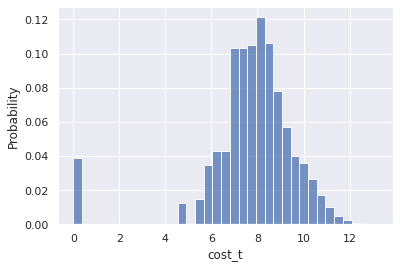

In [ ]:
# distribution of the costs

column_distribution(data, 'cost_t', group_column=None, is_count=False)

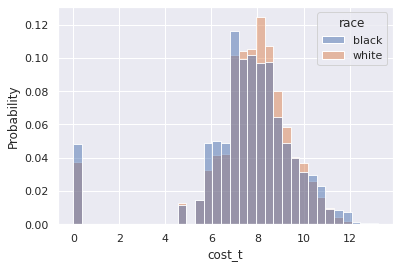

In [ ]:
# distribution of the costs for blacks and whites

column_distribution(data, 'cost_t', group_column='race', is_count=False)

## 4. Model Training (THE TEXT IS IMPORTANT, BUT NOT THE CODE, DO NOT CHANGE THE CODE)

The model is **Linear Regression**.

### Features (inputs)
1. Demographics
2. Chronic illnesses (Comorbidity variables at time t-1)
3. Detailed healthcare costs (Cost variables at time t-1)
4. Biomarkers (Biomarker/medication variables at time t-1) 

Note: The **race** variable is not included as a feature.

### Objective (output)
To allocate resources in a cost-efficient manner, the model predicts future expenditures costs (costs at year t: `cost_t`).

### The Risk Score
The risk score (`risk_score`) of each patient is based on the percentile he belongs to according to the model predictions. Percentiles are important for the company because the assingment to the “high-risk care management” program is based on them.

Through cost-benefit calculations, it was decided that patients above the 97th percentile are automatically identified for enrollment in the program. Those above the 55th percentile are referred to a physician.

In [ ]:
# splitting the data into train and test

train, test = train_test_split(data, test_size=0.4, random_state=42)
train, test = train.copy(), test.copy()

# defining the features (X_columns) and the target variable (y_column)
# IMPORTANT: we don't include the race variable to avoid discrimination.

X_columns = demographic_tm1 + comorbidities_tm1 + costs_tm1 + biomarkers_tm1
X_columns.remove('race')

y_column = 'cost_t'

# fit ,predict and evaluate

train_risk_scores, test_risk_scores = predict_risk_score(train, test, X_columns, y_column)
train['risk_score'] = train_risk_scores
test['risk_score'] = test_risk_scores

Finished training the model.


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


Evaluating the model:
	 Train Mean Squared Error (MSE): 850.0181313287283
	 Test Mean Squared Error (MSE): 909.5434711385803


## 5. Risk Score Analysis (THE REALLY IMPORTANT PART)

The functions below will be handy in this activity. The only parts you are allowed to change are the **column names in the functions' arguments**. But before you do that, make sure the you understand what you plan to check.


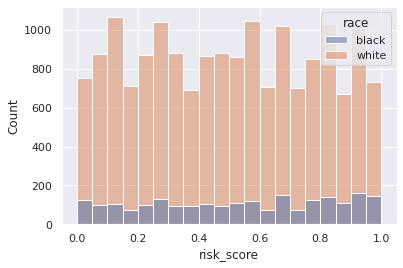

In [ ]:
# distribution of the risk scores

column_distribution(test, 'risk_score', group_column='race', cumulative=False,
                    is_count=True)

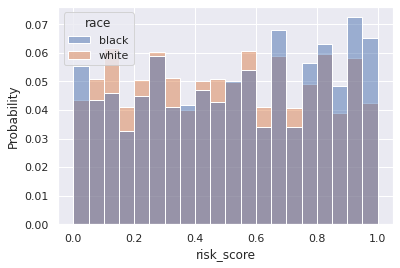

In [ ]:
column_distribution(test, 'risk_score', group_column='race', cumulative=False)

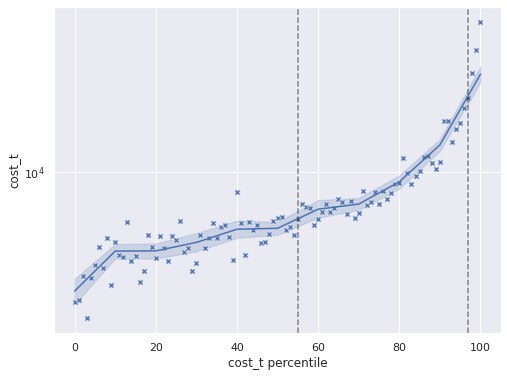

In [ ]:
plot_x_vs_y(test, 'risk_score', 'cost_t', group_column=None)

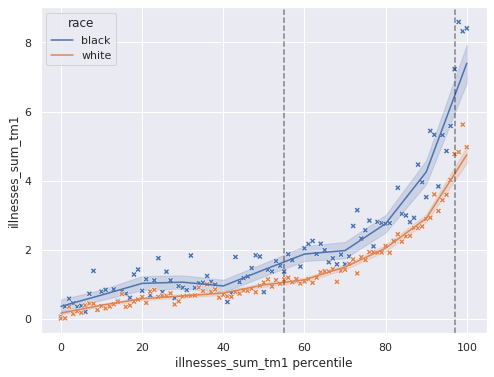

In [ ]:
comorbidities_tm1 = ['illnesses_sum_tm1', 'alcohol_elixhauser_tm1', 'anemia_elixhauser_tm1', 'arrhythmia_elixhauser_tm1', 'arthritis_elixhauser_tm1', 'bloodlossanemia_elixhauser_tm1', 'coagulopathy_elixhauser_tm1', 'compdiabetes_elixhauser_tm1', 'depression_elixhauser_tm1', 'drugabuse_elixhauser_tm1', 'electrolytes_elixhauser_tm1', 'hypertension_elixhauser_tm1', 'hypothyroid_elixhauser_tm1', 'liver_elixhauser_tm1', 'neurodegen_elixhauser_tm1', 'obesity_elixhauser_tm1', 'paralysis_elixhauser_tm1', 'psychosis_elixhauser_tm1', 'pulmcirc_elixhauser_tm1', 'pvd_elixhauser_tm1', 'renal_elixhauser_tm1', 'uncompdiabetes_elixhauser_tm1', 'valvulardz_elixhauser_tm1', 'wtloss_elixhauser_tm1', 'cerebrovasculardz_romano_tm1', 'chf_romano_tm1', 'dementia_romano_tm1', 'hemiplegia_romano_tm1', 'hivaids_romano_tm1', 'metastatic_romano_tm1', 'myocardialinfarct_romano_tm1', 'pulmonarydz_romano_tm1', 'tumor_romano_tm1', 'ulcer_romano_tm1']
plot_x_vs_y(test,'risk_score', 'illnesses_sum_tm1', group_column='race')